In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')


## Смотрим данные

In [6]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [7]:
data.shape, data.info(), data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

((10000, 20),
 None,
                 Id    DistrictId         Rooms        Square   LifeSquare  \
 count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
 mean    8383.40770     50.400800      1.890500     56.315775    37.199645   
 std     4859.01902     43.587592      0.839512     21.058732    86.241209   
 min        0.00000      0.000000      0.000000      1.136859     0.370619   
 25%     4169.50000     20.000000      1.000000     41.774881    22.769832   
 50%     8394.50000     36.000000      2.000000     52.513310    32.781260   
 75%    12592.50000     75.000000      2.000000     65.900625    45.128803   
 max    16798.00000    209.000000     19.000000    641.065193  7480.592129   
 
        KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
 count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
 mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
 std        28.560917      5.241

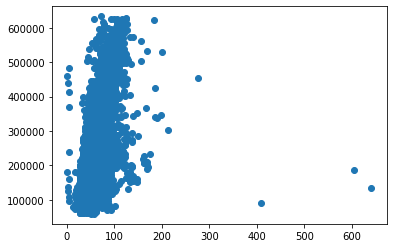

In [8]:
plt.scatter(data['Square'], data['Price'])

### Видим 4 точки выбросов. Огромная площадь за маленькую цену. 

(array([ 917., 2792., 3168., 1434.,  731.,  437.,  254.,  154.,   72.,
          41.]),
 array([ 59174.77802758, 116580.64688182, 173986.51573605, 231392.38459029,
        288798.25344453, 346204.12229876, 403609.991153  , 461015.86000724,
        518421.72886147, 575827.59771571, 633233.46656995]),
 <BarContainer object of 10 artists>)

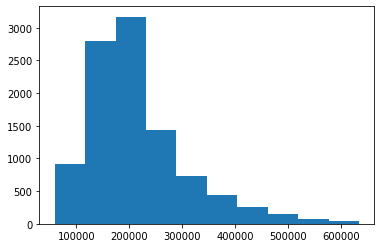

In [9]:
plt.hist(data['Price'])

### Распределение цен нормальное, оставляем без зменений.

## Обработка данных

### Меняем тип полей. Далее значения а и b заменяем на аналогичные числовые. 
Заполняем пропуски медианами. 
Заменяем сверхюольшую площадь на среднюю.
Заменяет сверхмаленькую площадь на 15 (на глаз)
Сверхбольшую и сверхмаленькую жилую площадь заменяем на 70% от общей.
Нулевые комнаты заменяем на 1 комнатную.

In [10]:
def fix(data):
    le = LabelEncoder().fit(data.Ecology_2)
    le.transform(data.Ecology_2)
    
    
    
    data['Id'] = data['Id'].astype(str)
    data['DistrictId'] = data['DistrictId'].astype(str)\


    
    data['Ecology_2'] = le.transform(data.Ecology_2)
    data['Ecology_3'] = le.transform(data.Ecology_3)
    data['Shops_2'] = le.transform(data.Shops_2)
    
    #data = data.replace('A', -1)
    #data = data.replace('B', 1)

    # Заполнили пропуски медианами. 
    data['Healthcare_1'] = data['Healthcare_1'].fillna(data['Healthcare_1'].median())
    data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].median())


    data.loc[data['Square'] > 250, 'Square'] = data['Square'].mean()
    data.loc[data['Square'] < 15, 'Square'] = 15
    
    data.loc[data['LifeSquare'] >= (data['Square'] * 0.95), 'LifeSquare'] = data['Square'] * 0.7
    data.loc[data['LifeSquare'] < (data['Square'] * 0.2), 'LifeSquare'] = data['Square'] * 0.7
    
    data.loc[data['Rooms'] == 0, 'Rooms'] = 1
    
    data['Ecology_2'] = data['Ecology_2'].astype(str)
    data['Ecology_3'] = data['Ecology_3'].astype(str)
    data['Shops_2'] = data['Shops_2'].astype(str)
    return data






## Нарезаем данные

In [11]:
data = fix(data)
data_test = fix(data_test)






In [12]:
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

(      Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
 0  11809         27    3.0  115.027311   32.781260           10.0      4   
 1   3013         22    1.0   39.832524   23.169223            8.0      7   
 2   8215          1    3.0   78.342215   47.671972           10.0      2   
 3   2352          1    1.0   40.409907   32.781260            1.0     10   
 4  13866         94    2.0   64.285067   38.562517            9.0     16   
 
    HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
 0        10.0       2014   0.075424         1         1        11      3097   
 1         8.0       1966   0.118537         1         1        30      6207   
 2        17.0       1988   0.025609         1         1        33      5261   
 3        22.0       1977   0.007122         1         1         1       264   
 4        16.0       1972   0.282798         1         1        33      8667   
 
    Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops

#### Исправили выбросы по площади. 

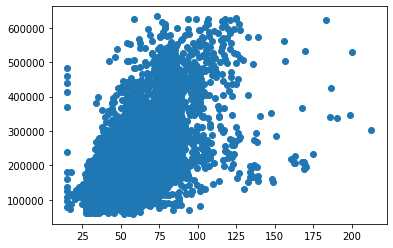

In [13]:
plt.scatter(data['Square'], data['Price'])

In [14]:
y = pd.DataFrame(data['Price'])
x = data
del x['Price']


#### Нормализовали данные. Для дерева не критично но так как тесты были на разных моделях решил оставить. 

In [15]:
scaler = StandardScaler().fit(x)
x = scaler.transform(x)
data_test = scaler.transform(data_test)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=5)



#### Моделька леса. Значения подобраны так, что бы снизить переобучение. 

In [17]:
model = RandomForestRegressor(n_estimators = 1000, max_depth = 9, max_features=4)
model.fit(x_train, y_train['Price'])


RandomForestRegressor(max_depth=9, max_features=4, n_estimators=1000)

In [18]:
y_pred = model.predict(x_test)
y_pred_t = model.predict(x_train)

In [19]:
answear = pd.DataFrame({'y_train': y_train['Price'], 'y_pred': y_pred_t.flatten()})
#answear

In [20]:
r2_score(y_train, y_pred_t)

0.8620159015731833

In [21]:
answear = pd.DataFrame({'y_test': y_test['Price'], 'y_pred': y_pred.flatten()})
#answear

In [22]:
r2_score(y_test, y_pred)

0.6714684041221426

### Как видно из графика категориальные признаки ранее имевшие значения А и В совершенно не играют роли. Пробовал их как то меняь, не помогло.

<BarContainer object of 19 artists>

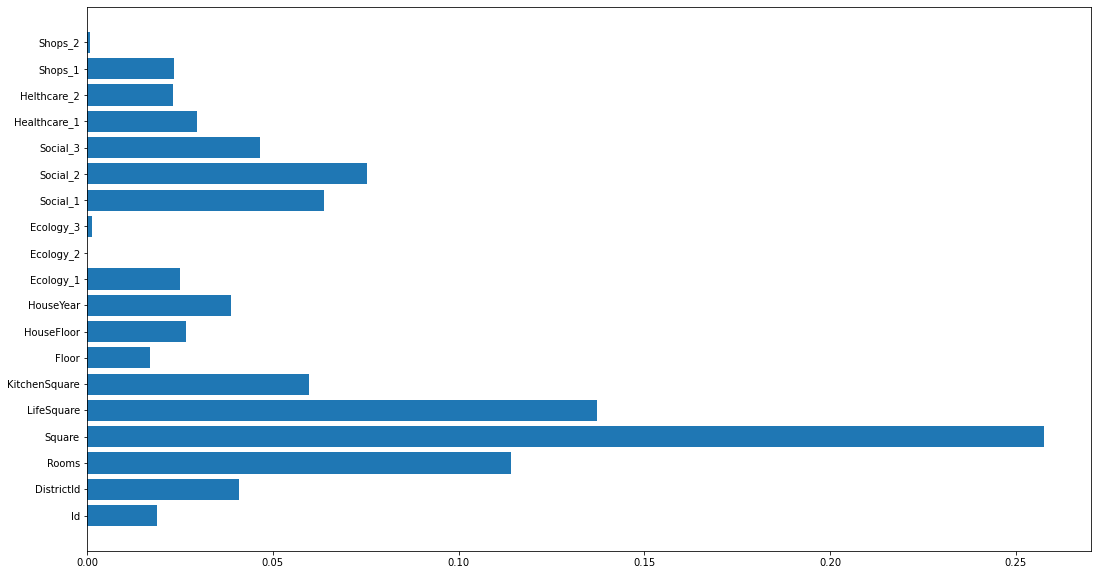

In [23]:
plt.figure(figsize=(18,10))
plt.barh(data.columns, model.feature_importances_)

In [24]:
submit = pd.read_csv('sample_submission.csv')
y_pred_test = model.predict(data_test)

submit['Price'] = y_pred_test
submit.to_csv('gb_predict.csv', index=False)

In [25]:
submit

,Id,Price
0,4567,159847.610120
1,5925,122897.122993
2,960,162865.988258
3,3848,145490.905528
4,746,194746.409771
...,...,...
4995,10379,196564.814202
4996,16138,399861.819927
4997,3912,155874.014797
4998,5722,175770.910675
